## Binary Image Classification Using mini-Xception

Qurat Ul Ain Syeda

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data2",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data2",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 546 files belonging to 2 classes.
Using 437 files for training.
Found 546 files belonging to 2 classes.
Using 109 files for validation.


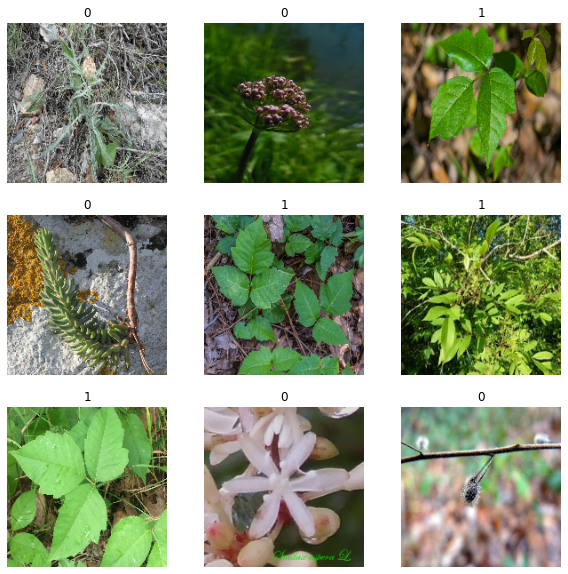

In [3]:
#1 is poisonous, 0 is non-poisonus
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        #layers.RandomCrop(),
        #layers.RandomTranslation(),
        #layers.RandomZoom(),
        #layers.RandomHeight(),
        #layers.RandomWidth(),
        #layers.RandomContrast(),
    ]
)

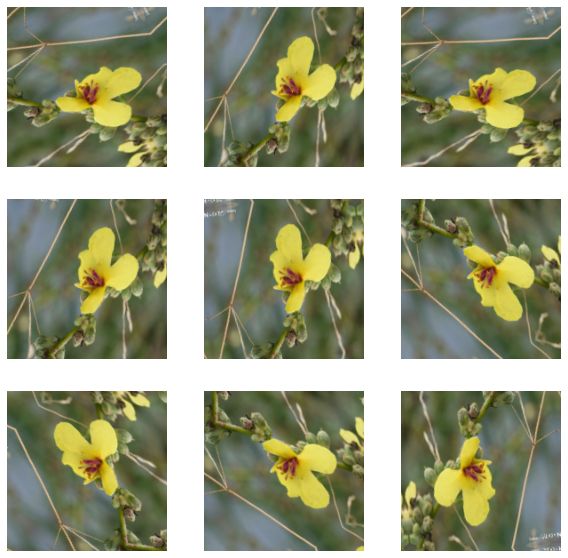

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
#Configure dataset for performance
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [7]:
#Make a small version of Xception model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = tf.keras.layers.Rescaling(1.0 / 255)(x)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [8]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

In [10]:
#Train the model
epochs = 50
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/50
14/14 [==============================] - 90s 6s/step - loss: 0.6943 - accuracy: 0.7002 - val_loss: 0.6930 - val_accuracy: 0.4954
Epoch 2/50
14/14 [==============================] - 80s 6s/step - loss: 0.4723 - accuracy: 0.7872 - val_loss: 0.6929 - val_accuracy: 0.5963
Epoch 3/50
14/14 [==============================] - 77s 5s/step - loss: 0.4419 - accuracy: 0.8330 - val_loss: 0.6946 - val_accuracy: 0.4954
Epoch 4/50
14/14 [==============================] - 80s 6s/step - loss: 0.3848 - accuracy: 0.8124 - val_loss: 0.6989 - val_accuracy: 0.4954
Epoch 5/50
14/14 [==============================] - 80s 6s/step - loss: 0.3643 - accuracy: 0.8490 - val_loss: 0.7120 - val_accuracy: 0.4954
Epoch 6/50
14/14 [==============================] - 73s 5s/step - loss: 0.3076 - accuracy: 0.8810 - val_loss: 0.7409 - val_accuracy: 0.4954
Epoch 7/50
14/14 [==============================] - 83s 6s/step - loss: 0.3306 - accuracy: 0.8467 - val_loss: 0.7729 - val_accuracy: 0.4954
Epoch 8/50
14/14 [==

In [11]:
model.evaluate(val_ds)

4/4 [==============================] - 4s 954ms/step - loss: 0.8025 - accuracy: 0.7523


[0.8025088310241699, 0.752293586730957]

In [12]:
model.save_weights('mini-xception.h5')

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

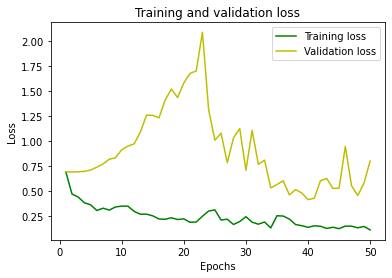

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
#epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'g', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

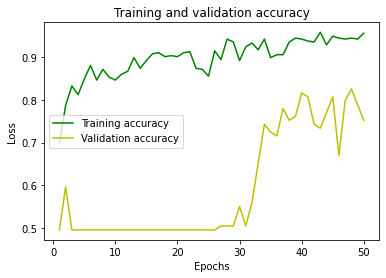

In [15]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Predicting on Test Set

This image is 0.00 percent non-poisonous and 100.00 percent poisonous.


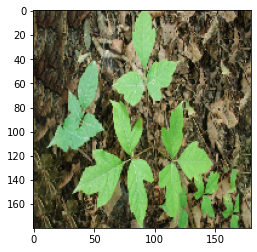

In [16]:
img = keras.preprocessing.image.load_img(
    "Dataset/Test/test_folder/Ivy-46.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
plt.imshow(img)
print(
    "This image is %.2f percent non-poisonous and %.2f percent poisonous."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent non-poisonous and 100.00 percent poisonous.


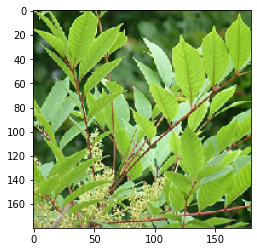

In [17]:
img = keras.preprocessing.image.load_img(
    "Dataset/Test/test_folder/poison_sumac_50.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
plt.imshow(img)
print(
    "This image is %.2f percent non-poisonous and %.2f percent poisonous."
    % (100 * (1 - score), 100 * score)
)

This image is 0.71 percent non-poisonous and 99.29 percent poisonous.


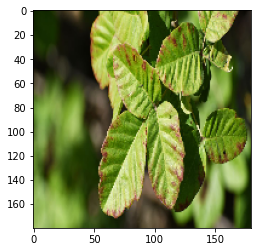

In [18]:
img = keras.preprocessing.image.load_img(
    "Dataset/Test/test_folder/Oak-46.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
plt.imshow(img)
print(
    "This image is %.2f percent non-poisonous and %.2f percent poisonous."
    % (100 * (1 - score), 100 * score)
)

This image is 99.99 percent non-poisonous and 0.01 percent poisonous.


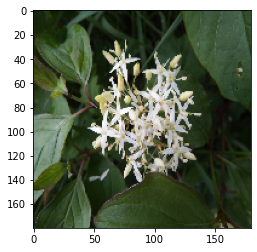

In [19]:
img = keras.preprocessing.image.load_img(
    "Dataset/Test/test_folder/2409.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
plt.imshow(img)
print(
    "This image is %.2f percent non-poisonous and %.2f percent poisonous."
    % (100 * (1 - score), 100 * score)
)